In [224]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot  as plt
%matplotlib inline
import requests

In [443]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

In [225]:
#Directory
path = os.getcwd() 
data_root = path + '\\DATA\\'
data_root

'C:\\Users\\Kaipable\\Desktop\\GitHub\\voter-protection-corps\\pollworkers_src\\DATA\\'

##  Common Congressional Election Survey Data

In [226]:
# Read in CCES data
cces = pd.read_csv(data_root + 'CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t')

#Explore 
print(cces.shape)
print(cces.columns)
cces.head(5)

C:\Users\Kaipable\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (46,47,48,49,50,51,52,53,54,55,370,371,373,374,375,376,377,378,379,380,381,382,383,385,386,388,389,390,391,393,394,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,419,420,422,423,424,425,426,427,430,432,436,439,441,443,445,446,447,448,449,450,451,452,453,454,455,456,458,460,462,486,487,493,494,513,515,520,522,526,527,528,533,534,535,541,542,543,544,545,559,560) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['V101', 'commonweight_vv', 'commonweight_vv_post',
       'commonweight_vv_lgbt', 'commonweight', 'commonweight_post', 'tookpost',
       'lookupzip', 'inputstate', 'cdid113',
       ...
       'CL_E2016PPEP', 'CL_E2016PPVM', 'CL_E2016PEP', 'CL_E2016PVM',
       'starttime_pre', 'endtime_pre', 'starttime_post', 'endtime_post', 'dma',
       'dmaname'],
      dtype='object', length=563)
64600


,V101,commonweight_vv,commonweight_vv_post,commonweight_vv_lgbt,commonweight,commonweight_post,tookpost,lookupzip,inputstate,cdid113,...,CL_E2016PPEP,CL_E2016PPVM,CL_E2016PEP,CL_E2016PVM,starttime_pre,endtime_pre,starttime_post,endtime_post,dma,dmaname
0,222168628,1.344214,1.042267,1.195346,0.944967,0.730450,1,3442,33,2,...,NaN,NaN,NaN,NaN,2016-10-20 05:05:44.887,2016-10-20 05:36:38.850,2016-11-16 06:24:32.895,2016-11-16 06:40:18.810,NaN,NaN
1,273691199,1.182352,1.280103,1.280565,0.767256,0.892838,1,70118,22,2,...,NaN,NaN,NaN,NaN,2016-10-23 14:54:58.548,2016-10-24 14:20:41.711,2016-11-30 14:02:55.143,2016-11-30 14:09:26.931,622.0,NEW ORLEANS
2,284214415,0.217396,NaN,0.248930,0.090604,0.000000,0,63851,29,8,...,NaN,NaN,NaN,NaN,2016-10-29 06:54:12.797,2016-10-29 07:24:44.759,NaN,NaN,632.0,PADUCAH-CAPE GIRARD-HARSBG
3,287557695,0.532320,NaN,0.928750,0.142583,0.000000,0,36703,1,7,...,NaN,NaN,NaN,NaN,2016-10-27 11:06:21.322,2016-10-27 11:26:00.051,NaN,NaN,698.0,MONTGOMERY-SELMA
4,290387662,1.261106,1.092519,1.161894,1.206498,1.019007,1,80526,8,2,...,NaN,NaN,NaN,NaN,2016-10-10 10:56:31.061,2016-10-10 11:14:12.215,2016-11-18 09:09:28.044,2016-11-18 09:21:05.905,751.0,DENVER


In [227]:
# Common Field
cces.countyfips[0:5]

0    33011.0
1    22071.0
2    29155.0
3     1047.0
4     8069.0
Name: countyfips, dtype: float64

In [228]:
#Clean Up County Code
cces['clean_county'] = cces['countyfips'].apply(lambda x: str(x).strip('.0')[-3:]   if len(str(x)) > 6 else '0'+ str(x).strip('.0')[0:2])
print(cces['clean_county'][0:5])

# Clean Up State Codes
cces['clean_state'] = cces['inputstate'].apply(lambda x: str(x) if len(str(x)) > 1 else '0'+ str(x))
#print(cces['clean_state'][0:5])

# Altogether;  Cretae FIPS Column
cces['FIPSCode'] = cces['clean_state'] + cces['clean_county']

#Match Type of DF
#cces['FIPSCode']= pd.to_numeric(cces['FIPSCode'], errors='coerce').fillna(0).astype(np.int64)
print(cces['FIPSCode'][0:5])

0    011
1    071
2    155
3    010
4    080
Name: clean_county, dtype: object
0    33011
1    22071
2    29155
3    01010
4    08080
Name: FIPSCode, dtype: object


In [229]:
#Investigate Voter Wait Time Column
percent_null = cces['CC16_404'].isna().sum() / len(cces.index)

print('Of the',len(cces.index), 'rows in the CCES dataset,', np.round(percent_null*100,2), '% of wait time entries are null.')
print('CCES has data from',cces['FIPSCode'].nunique(), 'counties')

#Categorical Data Codes
vote_dict = {1:0, 2: 'Less than 10', 3: '10-30 minutes', 4: '31 minutes - 1 hour', 5: 'more than one hour', 6: None}

Of the 64600 rows in the CCES dataset, 46.82 % of wait time entries are null.
CCES has data from 2408 counties


In [445]:
#DF for Just Vote Times to Merge
vote_times = cces[['V101','inputstate','FIPSCode','CC16_404']]
vote_times['CC16_404'] = vote_times['CC16_404'].replace(6,np.NaN) # 6 equates to NaN
vote_times = vote_times.dropna()

# Interpretable variable names. 
vote_times.columns = ['caseid','state','FIPSCode', 'wait_time'] 

#Did it Work?
vote_times.describe()

vote_times['wait_time'].dtype
print('We have vote times for',vote_times['FIPSCode'].nunique(), 'counties')
vote_times.head()

We have vote times for 2182 counties


C:\Users\Kaipable\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,caseid,state,FIPSCode,wait_time
0,222168628,33,33011,2.0
1,273691199,22,22071,1.0
4,290387662,8,08080,1.0
6,292860642,48,48231,2.0
8,295717127,13,13213,2.0


In [233]:
# Average Times by County
vote_by_fips = vote_times.groupby('FIPSCode', 
                as_index=False)['wait_time'].agg({'wait_time':'mean',
                  'wait_count': 'count'})
vote_by_fips.head()

,FIPSCode,wait_time,wait_count
0,01010,2.250720,347
1,01011,1.953846,130
2,02020,1.840909,44
3,02021,1.695652,23
4,02022,1.000000,2


 ## We The Action Dataset

In [235]:
wta = pd.read_csv(data_root +'users-2020-05-20_WTA.csv')

print(wta.shape)
wta.head(3)

13592


,Address state code,Address city,Zip code
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN


In [236]:
# Half of these rows are empty
print('{0:.1f} % of rows are missing'.format(wta['Zip code'].isna().sum() / len(wta.index) *100))

#Drop missing values
wta = wta.dropna()
wta['Zip code'] = wta['Zip code'].astype(int).astype(str)
wta.head()

53.2 % of rows are missing


,Address state code,Address city,Zip code
3,DC,Washington,20016
5,CA,Albany,94707
8,IL,Chicago,60657
11,NY,Brooklyn,11216
12,NM,Santa Fe,87507


In [237]:
# Map Zip to County
df_zcta = pd.read_csv(data_root+'zcta_county_rel_10.txt',sep=',', dtype='str')
zcta_values = df_zcta.values

# Dictionary to Map zip codes to FIPS, modified from polling locations
zcta_to_county = {}
for i in range(len(zcta_values)):
        zip_code = zcta_values[i,0]
        county_id = str(zcta_values[i,1]) + str(zcta_values[i,2]) 
        zcta_to_county[zip_code]=county_id
#zcta_to_county #check

#Map to WTA Data
wta['FIPSCode'] = wta['Zip code'].map(zcta_to_county)
wta.head(3)

,Address state code,Address city,Zip code,FIPSCode
3,DC,Washington,20016,11001
5,CA,Albany,94707,06013
8,IL,Chicago,60657,17031


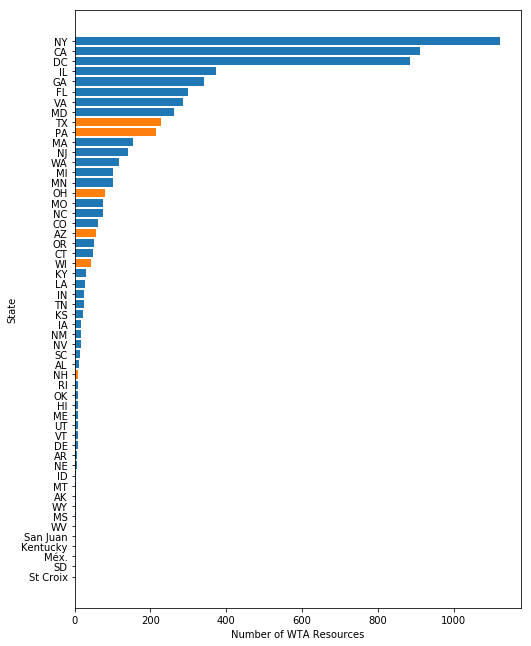

In [238]:
#Undertand WTA Presence, State Level
state_counts = wta[['Address state code', 'Zip code']].groupby('Address state code',as_index=False).size()
state_counts = state_counts.reset_index(name='wta_state_counts').sort_values(by='wta_state_counts')
type(state_counts)

#Visualize Where  Resources Are
fig= plt.figure(figsize=(8,11))
plt.barh('Address state code', 'wta_state_counts', data=state_counts)
plt.xlabel("Number of WTA Resources")
plt.ylabel("State")

#Just key states
key_states = ['TX','OH', 'NH', 'AZ', 'PA', 'WI']
wta_key = state_counts[state_counts['Address state code'].isin(key_states)]
plt.barh('Address state code', 'wta_state_counts', data=wta_key)  
plt.savefig("wta_presence.png")

In [239]:
#fips = wta[['FIPSCode','Zip code']] .groupby('FIPSCode', as_index=False).agg(['count'])
wta_resources = wta[['FIPSCode','Zip code']] .groupby('FIPSCode', as_index=False).size()
wta_resources=wta_resources.reset_index(name='wta_counts')

print('WTA has resources in', wta_resources.FIPSCode.nunique(), 'counties') #about 10%

# Number of Resources per FIPS Code
wta_resources.head()

WTA has resources in 398 counties


,FIPSCode,wta_counts
0,01073,8
1,01089,1
2,01101,1
3,01115,1
4,01117,1


# Get EAVS Dataset

#### Poll Worker Age
* D8a. TOTAL number of poll workers  
* D8b. Under 18 years old  
* D8c. 18 to 24  
* D8d. 26 to 40  
* D8e. 41 to 60  
* D8f. 61 to 70  
* D8g. 71 years old and over  

#### Section A: Voter Registration  
General info about registration numbers, forms processed, mode, and decision  
* A1a Total  Registered Voters
* Number of Active (A1b) and Inactive Voters (A1c)  
** Percent inactive (A1c/A1a) could communicate folks whose registration will take longer -- longer wait times > more resources
* % Same Day Registration
* Total # of same day registration (A2a)
* all registered voters (A1a)
* all new registrations (A3b)
* total processed registrations (A3a) in time frame

* Perhaps as percentage of registrations (A3b)  


#### Section D: Total Votes Cast an In-Person Voting  
Includes number of in-person voters, # precincts, # of polling places, # of poll workers, # in-person absentee  
* Total number of votes cast (D1a)  
* Total number voting in-person, physical voters (D2)
* In-person on election day (D2a)
* Early vote in-person (D2b)
* of Precincts (D3)
* Physical Polling Places (D4a)
Early vote (D5a) 
* Non-election office polling places (D5c)    

#### POLL WORKERS  
* Total # Poll workers (D8a)  
For election day (D6)  
For early voting (D7)  
* Ease of Recruiting Poll Workers (D9)  

#### PARTICIPATION  
* F1a. TOTAL number of voters participating
* F1b. Voted at a physical polling place on Election Day  


#### Summary:  New Vars to Add
* In Person Election Day Votes / Total Cotes Cast = D2 / D1 
    - In Person Election Day VOTERS / Total Voters = F1b/F1a
* Total Number of Poll Workers = D8a
* PENDING: Technology



In [365]:
#df = pd.read_excel('../DATA/EAVS_2018_for_Public_Release.xlsx')
df = pd.read_excel(data_root +'EAVS_2018_for_Public_Release_Updates.xlsx', dtype=str)
print(len(df))
#df.head(30)

6460


In [366]:
num_muni = df.groupby(['State_Abbr']).count()
num_muni.head()

,FIPSCode,Jurisdiction_Name,State_Full,A1a,A1b,A1c,A1Comments,A2a,A2Comments,A3a,...,F11d_4,F11d_5,F5_F11Comments,F12a,F12b,F12c,F12d,F12e,F12Comments,F13
State_Abbr,,,,,,,,,,,,,,,,,,,,,
AK,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AL,67,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,67,67,67,67,67
AR,75,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75
AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AZ,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15


In [367]:
# Clean Up
df = df.replace('Does not apply', None)
df = df.replace('Data not available', np.nan)
df = df.replace('NaN', None)
df = df.replace('Data not available', None)

In [368]:
# Necessary EAVS fields
eavs_vars = [ 'A1a', 'A1c', 'D1a','D2a','D2b', 'D4a', 'D4b', 'D6','D8f', 'D8g','D8a','F1b', 'F1a', 'F5c_1', 'F6c_1','F7c_1', 'F8c_1', 'F9c_1', 'F10c_1','F5c_2', 'F6c_2','F7c_2', 'F8c_2', 'F9c_2', 'F10c_2','F5c_3', 'F6c_3','F7c_3', 'F8c_3', 'F9c_3', 'F10c_3', 'D3a', 'C1a', 'C4a']

#Type Conversion
df[eavs_vars] = df[eavs_vars].astype('float64')

# All Vars Containing # of Machines
machine_vars = [k for k in eavs_vars if 'c_' in k ]
#df[machine_vars].head()



###  Wisconsin Procesing
- WI has "refused" for all difficulty columns

In [369]:
#Prepare to aggregate numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


#Wisconsin  Personal Time
wi_df = df[df['State_Abbr']=='WI']
df =  df[df['State_Abbr']!='WI']

#Create Common Column; EAVS has long and short form FIPS Codes
df['short_fips'] =df.FIPSCode.apply(lambda x: str(x)[0:5])

wi_df['Jurisdiction Name'] = wi_df.Jurisdiction_Name.str.split("- ").str[1]
wi_df['State_Code'] = '55'
wi_df['Jurisdiction_Name'] = wi_df['Jurisdiction Name']


#Get True FIPS from external  source
wi_names = pd.read_csv(data_root +'wi_counties.csv')
wi_names['Full_County_Name'] = wi_names['Full_County_Name'].astype(str)
wi = wi_df.merge(wi_names, how="left", left_on='Jurisdiction_Name', right_on='Full_County_Name')

wi = wi.dropna(subset=['short_fips'])
wi['short_fips'] = wi['short_fips'].astype(int)
wi['short_fips'] = wi['short_fips'].astype(str)
wi = wi.set_index(['short_fips', 'Jurisdiction_Name', 'State_Full', 'State_Abbr'])
wi = wi.select_dtypes(include=numerics)
wi.head()

A1a     A1c    C1a  \
short_fips Jurisdiction_Name State_Full State_Abbr                          
55083      OCONTO COUNTY     WISCONSIN  WI          1218.0  5636.0  118.0   
55067      LANGLADE COUNTY   WISCONSIN  WI           325.0  5636.0   15.0   
55001      ADAMS COUNTY      WISCONSIN  WI           905.0  5636.0   42.0   
                                        WI           740.0  5636.0   33.0   
55045      GREEN COUNTY      WISCONSIN  WI           337.0  5636.0   15.0   

                                                    C4a    D1a    D2a   D2b  \
short_fips Jurisdiction_Name State_Full State_Abbr                            
55083      OCONTO COUNTY     WISCONSIN  WI          0.0  919.0  795.0   0.0   
55067      LANGLADE COUNTY   WISCONSIN  WI          0.0  266.0  247.0   4.0   
55001      ADAMS COUNTY      WISCONSIN  WI          0.0  675.0  574.0  68.0   
                                        WI          3.0  609.0  581.0   0.0   
55045      GREEN COUNTY      WISCONSIN  WI          0.0  279.0  267.0   6.0   

                                                    D3a  D4a  D4b   ...    \
short_fips Jurisdiction_Name State_Full State_Abbr                  ...     
55083      OCONTO COUNTY     WISCONSIN  WI          1.0  1.0  1.0   ...     
55067      LANGLADE COUNTY   WISCONSIN  WI          1.0  1.0  1.0   ...     
55001      ADAMS COUNTY      WISCONSIN  WI          1.0  1.0  1.0   ...     
                                        WI          1.0  1.0  1.0   ...     
55045      GREEN COUNTY      WISCONSIN  WI          1.0  1.0  1.0   ...     

                                                    F7c_3  F8c_1  F8c_2  \
short_fips Jurisdiction_Name State_Full State_Abbr                        
55083      OCONTO COUNTY     WISCONSIN  WI            NaN    NaN    NaN   
55067      LANGLADE COUNTY   WISCONSIN  WI            NaN    NaN    NaN   
55001      ADAMS COUNTY      WISCONSIN  WI            NaN    NaN    NaN   
                                        WI            NaN    NaN    NaN   
55045      GREEN COUNTY      WISCONSIN  WI            NaN    NaN    NaN   

                                                    F8c_3  F9c_1  F9c_2  \
short_fips Jurisdiction_Name State_Full State_Abbr                        
55083      OCONTO COUNTY     WISCONSIN  WI            NaN    NaN    NaN   
55067      LANGLADE COUNTY   WISCONSIN  WI            NaN    NaN    NaN   
55001      ADAMS COUNTY      WISCONSIN  WI            NaN    NaN    NaN   
                                        WI            NaN    NaN    NaN   
55045      GREEN COUNTY      WISCONSIN  WI            NaN    NaN    NaN   

                                                    F9c_3  F10c_1  F10c_2  \
short_fips Jurisdiction_Name State_Full State_Abbr                          
55083      OCONTO COUNTY     WISCONSIN  WI            NaN     NaN     NaN   
55067      LANGLADE COUNTY   WISCONSIN  WI            NaN     NaN     NaN   
55001      ADAMS COUNTY      WISCONSIN  WI            NaN     NaN     NaN   
                                        WI            NaN     NaN     NaN   
55045      GREEN COUNTY      WISCONSIN  WI            NaN     NaN     NaN   

                                                    F10c_3  
short_fips Jurisdiction_Name State_Full State_Abbr          
55083      OCONTO COUNTY     WISCONSIN  WI             NaN  
55067      LANGLADE COUNTY   WISCONSIN  WI             NaN  
55001      ADAMS COUNTY      WISCONSIN  WI             NaN  
                                        WI             NaN  
55045      GREEN COUNTY      WISCONSIN  WI             NaN  

[5 rows x 34 columns]

In [370]:
#Prepare to Aggregate
sum_list = [ name for name in wi.columns if name != 'D9']
agg_dict = { var:'sum' for var in sum_list}
wi_agg = wi.reset_index().groupby(['short_fips', 'Jurisdiction_Name', 'State_Full', 'State_Abbr']).agg(agg_dict).reset_index()
#wi_agg

In [371]:
df = df.append(wi_agg, sort=False)

In [372]:
df[df['State_Abbr']=='WI'].short_fips

0     55001
1     55003
2     55005
3     55007
4     55009
5     55011
6     55013
7     55015
8     55017
9     55019
10    55021
11    55023
12    55025
13    55027
14    55029
15    55031
16    55033
17    55035
18    55037
19    55039
20    55041
21    55043
22    55045
23    55047
24    55049
25    55051
26    55053
27    55055
28    55057
29    55059
      ...  
41    55081
42    55083
43    55085
44    55087
45    55089
46    55091
47    55093
48    55095
49    55097
50    55099
51    55101
52    55103
53    55105
54    55107
55    55111
56    55113
57    55115
58    55117
59    55119
60    55121
61    55123
62    55125
63    55127
64    55129
65    55131
66    55133
67    55135
68    55137
69    55139
70    55141
Name: short_fips, Length: 71, dtype: object

In [373]:
# Better Labels
df['eligible_voters'] = df['A1a']
df['num_inactive'] = df['A1c']
df['num_same_day_pollworkers'] = df['D6']
df['num_machines'] = df[machine_vars].sum(axis=1, skipna=True)
df['in_person_voters'] = df['D2a'] #
df['num_pollworkers'] = np.where(pd.notna(df['num_same_day_pollworkers']), df['num_same_day_pollworkers'], df['D8a'])
df['num_same_day_locations'] = df['D4a']
df['num_pw_old'] = df['D8f'] + df['D8g']
####
df['voters_removed'] = df['A9a']
df['num_precincts'] = df['D3a']
df['total_mail_ballots'] =  df['C3a']
df['num_in_person'] = df['F1b'] 


# New Risk Features
#Historical Characteristics
df['percent_in_person'] = df['F1b'] / df['F1a']
df['percent_inactive'] = df['num_inactive'] / df['eligible_voters']

df['percent_early_vote'] = df['D2b'] / df['D1a']
df['percent_rejected_ballot'] = df['C4a'] / df['C1a']

# Recode Difficulty Survey
difficulty = {
    'Very difficult':5,
    'Somewhat difficult':4,
    'Neither difficult nor easy':3,
    'Somewhat easy':2,
    'Very easy':1,
    'Not enough information to answer':None  
}
df['difficulty'] = df['D9'].map(difficulty)
#df.difficulty.unique()

#Resources
df['voter_per_location'] = df['eligible_voters'] / df['num_same_day_locations']
df['voter_per_machine'] =  df['eligible_voters']/ df['num_machines']
df['voter_per_pw'] = np.where(pd.notna(df['num_same_day_pollworkers']), df['eligible_voters'] / 
                    df['num_same_day_pollworkers'], df['eligible_voters']/ df['num_pollworkers'] )

#Blended
df['total_resources_per_voter'] = df['eligible_voters'] / (df['num_machines'] + df['num_pollworkers'])

#Demographic
df['num_pw_old'] = df['D8f'] + df['D8g']
df['frac_pw_old'] = df['num_pw_old'] / df['D8a']

In [374]:
df.total_resources_per_voter[0:5]

0    242.500000
1    242.007800
2    139.701613
3    158.266667
4    224.220339
Name: total_resources_per_voter, dtype: float64

## Merge Data Before Individual State Subsetting

In [375]:

# Cast FIPS to Integer
df.short_fips = df.short_fips.astype(str)
vote_by_fips.FIPSCode = vote_by_fips.FIPSCode.astype(str)
wta_resources.FIPSCode = wta_resources.FIPSCode.astype(str)

In [376]:
#Merge WTA
eavs_wta = df.merge(wta_resources, how="left", left_on='short_fips', right_on='FIPSCode')

In [377]:
# Merge with Vote Time
df = eavs_wta.merge(vote_by_fips, how="left", left_on='short_fips', right_on='FIPSCode')
df.head(50)

,FIPSCode_x,Jurisdiction_Name,State_Full,State_Abbr,A1a,A1b,A1c,A1Comments,A2a,A2Comments,...,voter_per_location,voter_per_machine,voter_per_pw,total_resources_per_voter,frac_pw_old,FIPSCode_y,wta_counts,FIPSCode,wait_time,wait_count
0,0100100000,AUTAUGA COUNTY,ALABAMA,AL,39770.0,36391,3379.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,2093.157895,864.565217,337.033898,242.500000,0.813559,NaN,NaN,NaN,NaN,NaN
1,0100300000,BALDWIN COUNTY,ALABAMA,AL,155127.0,141301,13826.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,3165.857143,1251.024194,300.052224,242.007800,0.820116,NaN,NaN,NaN,NaN,NaN
2,0100500000,BARBOUR COUNTY,ALABAMA,AL,17323.0,15871,1452.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,184.287234,524.939394,190.362637,139.701613,0.791209,NaN,NaN,NaN,NaN,NaN
3,0100700000,BIBB COUNTY,ALABAMA,AL,14244.0,13245,999.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,1780.500000,749.684211,200.619718,158.266667,0.732394,NaN,NaN,NaN,NaN,NaN
4,0100900000,BLOUNT COUNTY,ALABAMA,AL,39687.0,37352,2335.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,1526.423077,763.211538,317.496000,224.220339,0.832000,NaN,NaN,NaN,NaN,NaN
5,0101100000,BULLOCK COUNTY,ALABAMA,AL,7472.0,6772,700.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,111.522388,149.440000,73.254902,49.157895,0.558824,NaN,NaN,01011,1.953846,130.0
6,0101300000,BUTLER COUNTY,ALABAMA,AL,14079.0,13161,918.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,639.954545,281.580000,93.860000,70.395000,0.787500,NaN,NaN,NaN,NaN,NaN
7,0101500000,CALHOUN COUNTY,ALABAMA,AL,76168.0,69851,6317.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,1655.826087,785.237113,238.025000,182.657074,0.887500,NaN,NaN,NaN,NaN,NaN
8,0101700000,CHAMBERS COUNTY,ALABAMA,AL,24367.0,22474,1893.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,1218.350000,435.125000,487.340000,229.877358,0.240000,NaN,NaN,NaN,NaN,NaN
9,0101900000,CHEROKEE COUNTY,ALABAMA,AL,17893.0,16808,1085.0,nan,Does not apply,ALABAMA DOES NOT HAVE SAME DAY REGISTRATION.,...,777.956522,331.351852,144.298387,100.522472,0.750000,NaN,NaN,NaN,NaN,NaN


In [378]:
df.isnull().sum().head()

FIPSCode_x           71
Jurisdiction_Name     0
State_Full            0
State_Abbr            0
A1a                  11
dtype: int64

* Use Ohio
* Compute all variables that have missing data = WAIT TIMES and DIFFICULTY
* for each variable, boolean column (Is_imputed)
* go through each variable, and figure out imputation strategy
* FOR EXAMPLE: wait times dependent on # of people,  # of location, # of people
== use to define closest county (Euclidean distance)
* Difficulty_recruiting = geography -- population (random forest)
* predict recruiting difficulty (logistic regression) then try to predict

Potential Methods
* Build models to predict wait times and difficulty (ordinal)
* Regression for wait times
* Multi-class for difficulty

Next Steps
- start fitting models to these cases and choose the best *
- fill all missing values with wait times and include the confidence intervals
- think about blending value with CI
- keep the boolean
- plot correlations !  = potentially address if highly correlated


OUTPUT : three columns per variable
* is_imputed, confidence_classifier, predicted_value
* correlation column or plot

Final Visualization
* setup discussion with Rayid about viz (Hemank asking Jess)


* Include  imputated columns in the Borda Ranking
* give more weight to is_imputed
* how much is your confidence in the imputed values



## Add Geospatial  Information

In [379]:
# # Read In Shape Files
# filepath = data_root + "\\tl_2016_us_county\\tl_2016_us_county.shp"
# shapes = gpd.read_file(filepath)
# print(shapes.head())

# #Did It Work?
# type(shapes)
# shapes.plot(figsize=(5,5))

In [380]:
# gdf = shapes.merge(df, how='inner', left_on="GEOID", right_on="short_fips")
# print(gdf.columns)
# gdf.head()

In [381]:
# # # Where are the WTA Resources?
# wta_geo = gdf[gdf['wta_counts'] >= 0]

# #Create list of WTA resource counties
# wta_counties = wta_geo.NAME.unique()
# wta_counties

# #Nearby resources takes a long time to compute; have this output stored
# gdf["nearby_resources"] = None
# for index, county in gdf.iterrows():   
#     # get 'not disjoint' countries
#     neighbors = gdf[~gdf.geometry.disjoint(county.geometry)].NAME.tolist()
#     # remove own name from the list
#     neighbors = [ name for name in neighbors if county.NAME != name and name in wta_counties]
#     gdf.at[index, "nearby_resources"] = ", ".join(neighbors)

In [382]:
#gdf[gdf['State_Abbr']=='WI'].head()

In [383]:
# INVESTIGATE WAIT TIMES
# vote_by_fips_sorted1 = df.groupby(['State_Abbr'], as_index=False)['wait_time'].mean().sort_values(by='wait_time', ascending=False)

# vote_by_fips_sorted2 = df.groupby(['State_Abbr'], as_index=False)['wait_time'].count().sort_values(by='wait_time', ascending=False)
# vote_by_fips_sorted2.head(5)

TO DO

- completion rates for counties
- highlight data we are missing
- possibly impute missing data for counties


### Add Census Variables

In [384]:
acs = pd.read_csv(data_root+ 'all_states_census.csv', dtype='str')
print(acs.columns)
print(len(acs))

acs.head()

Index(['Unnamed: 0', 'index', 'DP05_0033E', 'DP05_0038E', 'DP05_0072E',
       'DP03_0063E', 'DP02_0001E', 'DP03_0062E', 'DP05_0018E', 'DP05_0014E',
       'DP05_0015E', 'DP05_0016E', 'DP05_0017E', 'fips_code', 'state_code',
       'Name', 'FIPS State Numeric Code', 'Official USPS Code'],
      dtype='object')
3220


,Unnamed: 0,index,DP05_0033E,DP05_0038E,DP05_0072E,DP03_0063E,DP02_0001E,DP03_0062E,DP05_0018E,DP05_0014E,DP05_0015E,DP05_0016E,DP05_0017E,fips_code,state_code,Name,FIPS State Numeric Code,Official USPS Code
0,0,"Washington County, Mississippi: Summary level:...",47086,33982,579,49433,18299.0,30834,36.9,3291,4282,1961,710,28151,28,Mississippi,28,MS
1,1,"Perry County, Mississippi: Summary level: 050,...",12028,2368,150,55077,4563.0,39007,40.9,897,1247,589,236,28111,28,Mississippi,28,MS
2,2,"Choctaw County, Mississippi: Summary level: 05...",8321,2596,14,49162,3164.0,37203,44.0,644,979,547,214,28019,28,Mississippi,28,MS
3,3,"Itawamba County, Mississippi: Summary level: 0...",23480,1681,320,53717,8706.0,40510,40.0,1435,2250,1181,574,28057,28,Mississippi,28,MS
4,4,"Carroll County, Mississippi: Summary level: 05...",10129,3503,2,57919,3658.0,43060,47.0,623,1353,726,170,28015,28,Mississippi,28,MS


### Understand ACS and  EAVS Incompatibility

In [385]:
#Understand How States Actually Submitted Their EAVS data
eavs_counties = df[['FIPSCode', 'State_Abbr']].groupby(['State_Abbr']).count().reset_index()

census_counties = acs[['fips_code','Official USPS Code']].groupby(['Official USPS Code']).count().reset_index()

get_disconnect = census_counties.merge(eavs_counties, how="left", left_on='Official USPS Code', right_on='State_Abbr')

get_disconnect = get_disconnect.drop(['State_Abbr'], axis=1)
get_disconnect.columns = ['State', 'Correct_Census_Count', 'EAVS_Count']
get_disconnect['county_match'] = get_disconnect['Correct_Census_Count'] == get_disconnect['EAVS_Count']

true_matches = get_disconnect.county_match.sum()

get_disconnect.head()

,State,Correct_Census_Count,EAVS_Count,county_match
0,AK,29,0,False
1,AL,67,1,False
2,AR,75,1,False
3,AZ,15,0,False
4,CA,58,1,False


In [386]:
print('There are', 50-true_matches, 'correct counties here.')

trouble_states = get_disconnect[get_disconnect['county_match']==False]
trouble_states.head()
#get_disconnect['match'] = get_disconnect

There are 46 correct counties here.


,State,Correct_Census_Count,EAVS_Count,county_match
0,AK,29,0,False
1,AL,67,1,False
2,AR,75,1,False
3,AZ,15,0,False
4,CA,58,1,False


In [387]:
#Create Common Field
#Intelligble Variable Names
acs['total_population'] = acs['DP05_0033E'].astype(int)
acs['black_population'] = acs['DP05_0038E'].astype(int)
acs['hispanic_population'] = acs['DP05_0072E'].astype(int)
acs['mean_household_income'] = acs['DP03_0063E'].astype(int)
acs['total_households'] = acs['DP02_0001E'].astype(float)
acs['median_household_income'] =  acs['DP03_0062E'].astype(int)
acs['median_age'] = acs['DP05_0018E'].astype(float)

#New Variables
acs['num_black_latino'] = acs['black_population'] + acs['hispanic_population']
acs['percent_minority'] = (acs['black_population'] + acs['hispanic_population']) /  acs['total_population']
acs['num_senior'] =  (acs['DP05_0014E'].astype(float) + acs['DP05_0015E'].astype(float) + acs['DP05_0016E'].astype(float) + acs['DP05_0017E'].astype(float)) 
acs['percent_over_60'] = (acs['DP05_0014E'].astype(float) + acs['DP05_0015E'].astype(float) + acs['DP05_0016E'].astype(float) + acs['DP05_0017E'].astype(float)) / acs['total_population']

keep_census = ['fips_code','percent_minority', 'percent_over_60', 'median_household_income','total_households','median_age', 'num_senior', 'num_black_latino', 'total_population',]

In [419]:
full_df = df.merge(acs[keep_census], how="left", left_on="short_fips", right_on="fips_code")

### Overview: State Trends
* Arizona and Wisconsin do not offer same day registration
* Pennsylvania is not required to report its number of poll workers
* Might sub NH for  Michigan

In [422]:
#Last minute fix
full_df['num_in_person'] = full_df['F1b'] 

In [441]:
# Units and Features of Interest
key_states = ['TX','OH', 'AZ', 'PA', 'WI', 'NC','FL', 'MI']

# #Features we want to keep in the final merge / Drop Excess Columns 
keep_vars = ['State_Full','short_fips', 'State_Abbr', 'Jurisdiction_Name', 'num_in_person','num_inactive','num_black_latino','num_senior', 'num_pw_old','difficulty', 
   'voter_per_location', 'voter_per_machine', 'voter_per_pw','total_resources_per_voter',  'wta_counts', 'wait_time','wait_count',  'eligible_voters', 'num_machines',
        #     'nearby_resources',
             
             'frac_pw_old', 'percent_in_person', 'percent_inactive',  'voter_per_machine', 'voter_per_pw', 'total_resources_per_voter', 'wait_time','wait_count', 'percent_minority', 'percent_over_60', 'num_same_day_locations', 'num_machines', 'num_pollworkers', 'num_pw_old', 'voters_removed', 'num_precincts', 'total_mail_ballots', 'percent_early_vote', 'percent_rejected_ballot',  'median_age', 'median_household_income', 'total_population']

#nearbyresources

# Features for Looping and Riskiness
risk_feats = ['short_fips', 'State_Abbr','eligible_voters','num_black_latino','num_senior', 'num_pw_old','difficulty','percent_in_person', 'percent_inactive', 'voter_per_location',  'voter_per_machine', 'voter_per_pw', 'total_resources_per_voter', 'wait_time']

# DF for Key States and Risk Variables
clean_df = full_df[keep_vars]
key_df = full_df[full_df['State_Abbr'].isin(key_states)][keep_vars]
print(key_df.head())


# oh_df = key_df[key_df['State_Abbr']=='OH'][keep_vars]
# oh_df.to_csv('ohio_raw_data.csv')

   State_Full short_fips State_Abbr Jurisdiction_Name  num_in_person  \
69    ARIZONA      04001         AZ     APACHE COUNTY        13440.0   
70    ARIZONA      04003         AZ    COCHISE COUNTY         8591.0   
71    ARIZONA      04005         AZ   COCONINO COUNTY        15391.0   
72    ARIZONA      04007         AZ       GILA COUNTY         3635.0   
73    ARIZONA      04009         AZ     GRAHAM COUNTY         3469.0   

    num_inactive  num_black_latino  num_senior  num_pw_old  difficulty  \
69        4971.0            3859.0     14758.0        99.0         4.0   
70       16381.0           44041.0     36129.0        77.0         4.0   
71       15500.0           17803.0     24202.0       161.0         4.0   
72        7433.0            9515.0     19272.0       161.0         5.0   
73        3250.0           12587.0      7083.0        25.0         3.0   

    voter_per_location  voter_per_machine  voter_per_pw  \
69         1306.666667        1193.043478    197.410072   
70  

In [442]:
# Output Final Risk Indicators Datarame
import pickle

clean_df.to_csv(data_root + 'all_states_risk_data.csv')
key_df.to_csv(data_root+'key_states_risk_data.csv')
key_df.to_pickle('key_states.pkl')
clean_df.to_pickle('all_df.pkl')

In [ ]:
key_df.head()

In [413]:
# Understand Which States Are Missing Which Values
import seaborn as sns
track_state_nas = key_df[risk_feats].set_index('State_Abbr').isna().sum(level=0)
num_counties = key_df[risk_feats].groupby(['State_Abbr']).count()
percent_missing = track_state_nas / num_counties
#sns.heatmap(percent_missing, annot=True)
percent_missing.to_csv('missing_matrix.csv')
track_state_nas.to_csv('count_nas_by_state.csv')
#track_state_nas.to_csv

In [440]:

track_all_nas = full_df[risk_feats].set_index('State_Abbr').isna().sum(level=0)
num_counties = full_df[risk_feats].groupby(['State_Abbr']).count()
percent_missing = track_all_nas / num_counties
percent_missing.to_csv('toolkit_ready_states.csv')

In [436]:
edf = pd.read_excel(data_root +'EAVS 2016 Final Data for Public Release v.4.xls', dtype=str)
print(len(df))


4681


,FIPSCode,State,JurisdictionName,A1a,A1Comments,A2,A2c_Other,A2_Comments,A3a,A3b,...,A11g,A11h_Other,A11h,A11i_Other,A11i,A11j_Other,A11j,A11k_Other,A11k,A11Comments
3318,3900100000,OH,ADAMS,16945,,Active voters only,,,16945,-888888: Not Applicable,...,36,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3319,3900300000,OH,ALLEN,68054,,Active voters only,,,68054,-888888: Not Applicable,...,49,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3320,3900500000,OH,ASHLAND,35452,,Active voters only,,,35452,-888888: Not Applicable,...,60,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3321,3900700000,OH,ASHTABULA,60624,,Active voters only,,,60624,-888888: Not Applicable,...,294,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3322,3900900000,OH,ATHENS,45418,,Active voters only,,,45418,-888888: Not Applicable,...,227,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3323,3901100000,OH,AUGLAIZE,31666,,Active voters only,,,31666,-888888: Not Applicable,...,11,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3324,3901300000,OH,BELMONT,46971,,Active voters only,,,46971,-888888: Not Applicable,...,145,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3325,3901500000,OH,BROWN,28405,,Active voters only,,,28405,-888888: Not Applicable,...,20,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3326,3901700000,OH,BUTLER,247972,,Active voters only,,,247972,-888888: Not Applicable,...,1048,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3327,3901900000,OH,CARROLL,18002,,Active voters only,,,18002,-888888: Not Applicable,...,26,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,


In [439]:
pd.set_option('display.max_columns', None)
edf[edf['State']=='OH'].head(30)

,FIPSCode,State,JurisdictionName,A1a,A1Comments,A2,A2c_Other,A2_Comments,A3a,A3b,A3Comments,A4a,A4b,A4b_Other,A4Comments,A5a,A5b,A5c,A5d,A5e,A5f,A5g,A5h_Other,A5h,A5i_Other,A5i,A5j_Other,A5j,A5k_Other,A5k,A5l_Other,A5l,A5Comments,A6a,A6b,A6c,A6d,A6e,A6f,A6g,A6h,A6i,A6j_Other,A6j,A6k_Other,A6k,A6l_Other,A6l,A6m_Other,A6m,A6n_Other,A6n,A6o_Other,A6o,A6Comments,A7a,A7b,A7c,A7d,A7e,A7f,A7g,A7h,A7i,A7j_Other,A7j,A7k_Other,A7k,A7l_Other,A7l,A7m_Other,A7m,A7n_Other,A7n,A7o_Other,A7o,A7Comments,A8a,A8b,A8c,A8d,A8e,A8f,A8g,A8h,A8i,A8j_Other,A8j,A8k_Other,A8k,A8l_Other,A8l,A8m_Other,A8m,A8n_Other,A8n,A8o_Other,A8o,A8Comments,A9a,A9b,A9c,A9d,A9e,A9f,A9g,A9h,A9i,A9j_Other,A9j,A9k_Other,A9k,A9l_Other,A9l,A9m_Other,A9m,A9n_Other,A9n,A9o_Other,A9o,A9Comments,A10a,A10b,A10c,A10d,A10e,A10f_Other,A10f,A10g_Other,A10g,A10h_Other,A10h,A10Comments,A11a,A11b,A11c,A11d,A11e,A11f,A11g,A11h_Other,A11h,A11i_Other,A11i,A11j_Other,A11j,A11k_Other,A11k,A11Comments
3318,3900100000,OH,ADAMS,16945,,Active voters only,,,16945,-888888: Not Applicable,,-888888: Not Applicable,-888888: Not Applicable,,,5852,2470,30,1332,156,1864,-888888: Not Applicable,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,1275,1130,0,2329,711,0,11,396,0,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,598,509,0,985,220,0,7,151,0,nan,-888888: Not Applicable,nan,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,303,275,-888888: Not Applicable,482,264,-888888: Not Applicable,0,8,-888888: Not Applicable,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,43,35,-888888: Not Applicable,19,53,-888888: Not Applicable,0,6,0,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,4560,1189,-888888: Not Applicable,397,2974,nan,-999999: Data Not Available,nan,-999999: Data Not Available,nan,-999999: Data Not Available,,2344,30,412,53,1813,0,36,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3319,3900300000,OH,ALLEN,68054,,Active voters only,,,68054,-888888: Not Applicable,,-888888: Not Applicable,-888888: Not Applicable,,,24775,9442,98,5825,25,9385,-888888: Not Applicable,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,2721,4243,0,12810,3880,54,0,1048,19,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,1367,1833,0,4241,1278,16,0,703,4,nan,-888888: Not Applicable,nan,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,633,875,-888888: Not Applicable,2561,1551,8,0,186,11,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,0,24,-888888: Not Applicable,1,0,0,0,0,0,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,,20012,5168,-888888: Not Applicable,1981,12863,nan,-999999: Data Not Available,nan,-999999: Data Not Available,nan,-999999: Data Not Available,,6260,3886,940,142,1242,1,49,,-999999: Data Not Available,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,
3320,3900500000,OH,ASHLAND,35452,,Active voters only,,,35452,-888888: Not Applicable,,-888888: Not Applicable,-888888: Not Applicable,,,13931,5767,0,4412,211,3541,-888888: Not Applicable,,0,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Applicable,nan,-888888: Not Ap

In [435]:
edf['inactive_voters'] = edf['A3b']
oh_edf= edf[edf['State']=='OH'][['FIPSCode','inactive_voters']]
oh_edf.to_csv('ohio_inactive.csv')

oh_edf.head()

,FIPSCode,inactive_voters
3318,3900100000,-888888: Not Applicable
3319,3900300000,-888888: Not Applicable
3320,3900500000,-888888: Not Applicable
3321,3900700000,-888888: Not Applicable
3322,3900900000,-888888: Not Applicable


In [433]:
edf[edf['State_Abbr']=='OH'].iloc[:][:20]

KeyError: 'State_Abbr'